<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/Camera_4gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
# -- mount google drive
from google.colab import drive
drive.mount("/content/drive")

# -- install geopandas
!pip install geopandas
!pip install gmaps

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**important import**

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gp
from shapely.geometry import Point

import pyproj
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import statistics

In [110]:
# -- read in the counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", "avg_weekend_ts.feather")
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", "cams_ft_wd.feather")
weekend = pd.read_feather(camera_fname)
weekday = pd.read_feather(fname)
weekend


avg_counts
0   129.397845
1   121.734639
2   111.055082
3   106.617686
4    95.229929
..         ...
91  146.531228
92  143.841594
93  133.757974
94  125.312416
95  118.645035

[96 rows x 1 columns]

In [0]:
week_end = weekend
week_end

avg_counts
0   129.397845
1   121.734639
2   111.055082
3   106.617686
4    95.229929
..         ...
91  146.531228
92  143.841594
93  133.757974
94  125.312416
95  118.645035

[96 rows x 1 columns]

In [0]:
# week_all = weekday.copy()

# for i in range(96):
#   for j in range(157):
#     val = week_end.iloc[0][i] + weekday.iloc[j][i + 3]
#     week_all.iat[j, i + 3] = val

# week_all #week_all就是加好的dataframe

In [0]:
camarr = weekday.drop(columns=["cam_id", "lat", "lon"]).values
camarr

array([[0.43766073, 0.2679036 , 0.30462441, ..., 0.49253703, 0.542913  ,
        0.45156403],
       [1.46057598, 1.18212648, 1.13072035, ..., 1.76761035, 1.66886608,
        1.50488759],
       [0.05269193, 0.04930822, 0.04520202, ..., 0.04076246, 0.04428152,
        0.05571848],
       ...,
       [0.10185728, 0.13059629, 0.09773116, ..., 0.12038123, 0.14794721,
        0.13247989],
       [0.73690127, 0.65676367, 0.53401321, ..., 0.78933754, 0.73993157,
        0.71253854],
       [0.50614332, 0.44565005, 0.42512432, ..., 0.81785097, 0.74364614,
        0.72141138]])

In [0]:
wendvals = week_end["avg_counts"]
wendvals_t = wendvals.T      #问问老师这里需不需要转，转之前是横着的还是竖着的
wendvals_t

In [0]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
#   amp = scl
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)

In [0]:
# -- define 4 fit model error
def res(param, xval, yval):
  m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param
  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
            gauss(xval, m3, sd3, scl3) + wamp * wendvals_t + off
  return yval - model

In [0]:
# -- set inital guess
avgs  = [35, 47, 70]
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [8]
param = avgs + sigs + scls + wamp + off

print(param)

[35, 47, 70, 3, 3, 3, 5, 5, 5, 8, 0.5]


In [0]:
# -- run the optimization (i.e., model fitting)
xval_final = np.arange(96)
plsq_final = []                       # [[a,b,c,d,...], [a,b,c,d,...]]


# GGD: We may need to write something here to check if the routine found a good solution
for i in range(len(camarr)):
#   print("working on {0}".format(i))
  
  plsq_final.append(leastsq(res, param, args=(xval_final, camarr[i])))


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 2400.
  warnings.warn(errors[info][0], RuntimeWarning)


In [0]:
def huatu(plsq, i, wdt): #我把wendvals_当做一个参数传进来了，这样你这个def代码块内部的wendvals_t就是指这个参数里的wendavls_t了
  m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq
  model = gauss(xval_final, m1, sd1, scl1) + gauss(xval_final, m2, sd2, scl2) + gauss(xval_final, m3, sd3, scl3) + wamp * wdt + off
  plt.plot(xval_final, camarr[i], label="data")
  plt.plot(xval_final, model, label="model")
  plt.xlabel("15 min time stamp index")
  plt.ylabel("raw counts")
  plt.legend()
  plt.show()      #call show()让每次循环都重新画一个新图

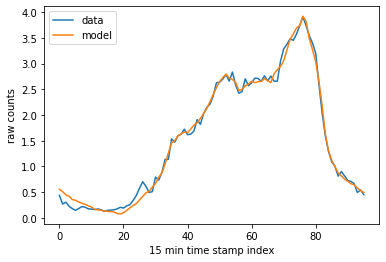

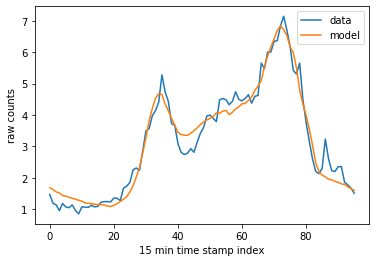

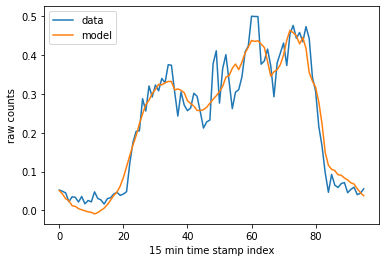

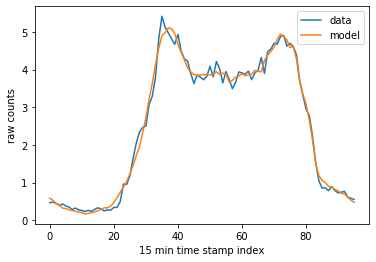

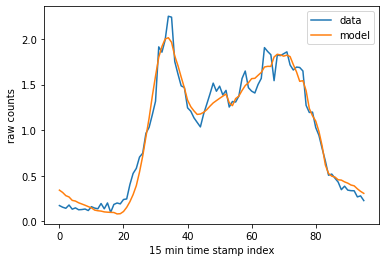

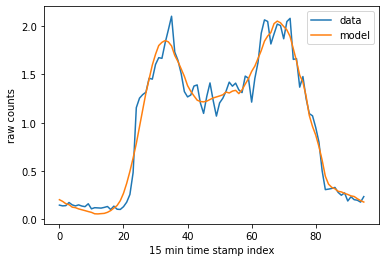

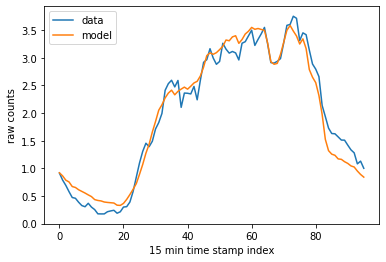

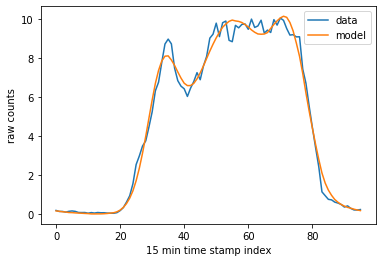

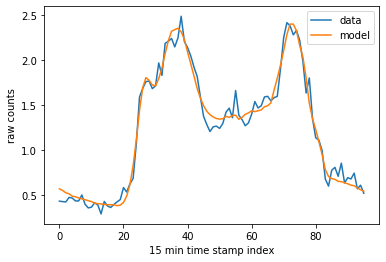

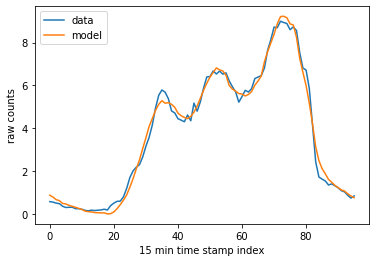

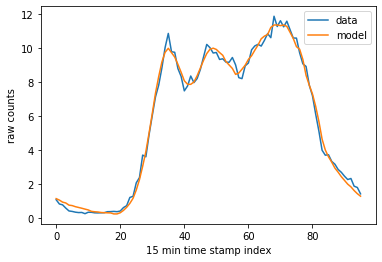

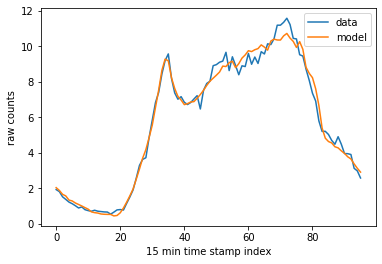

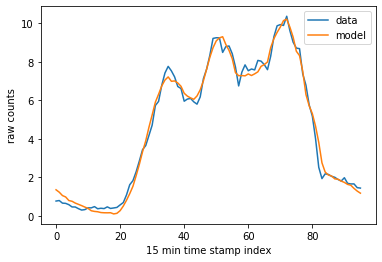

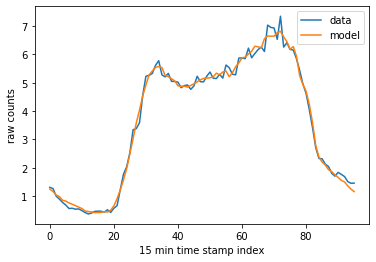

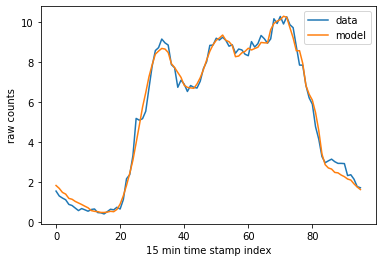

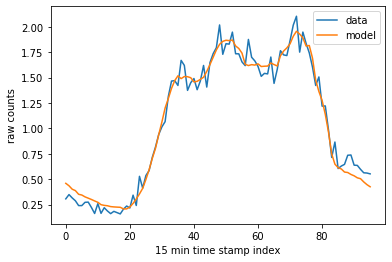

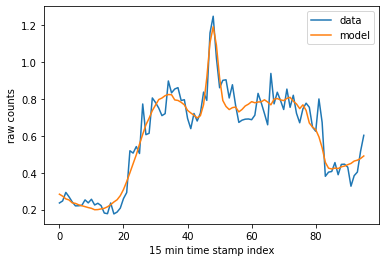

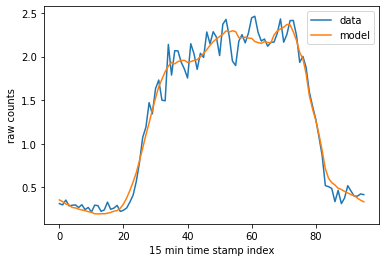

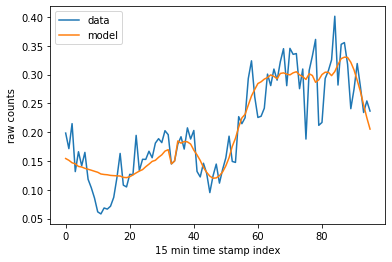

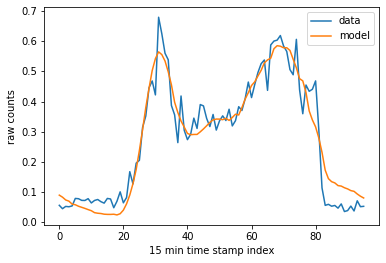

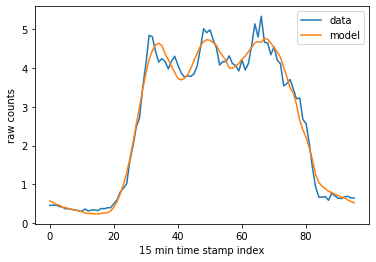

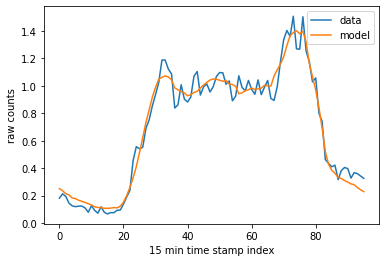

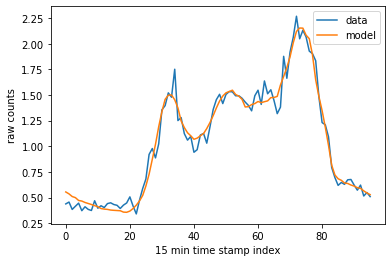

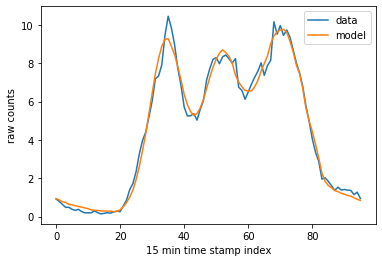

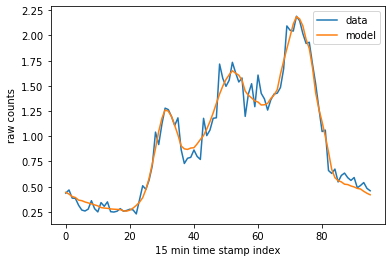

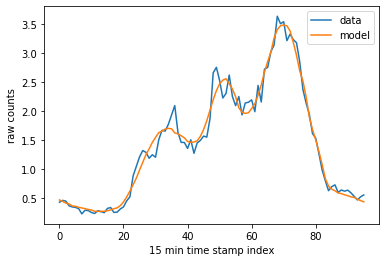

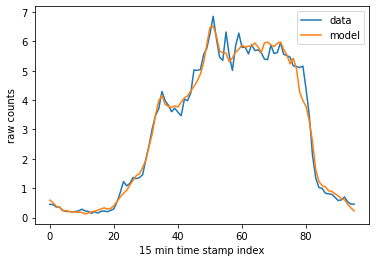

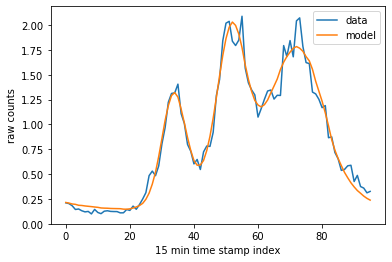

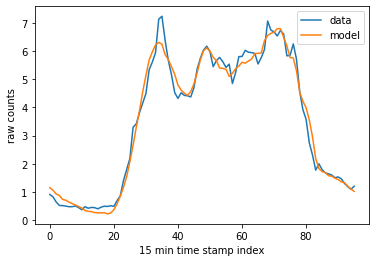

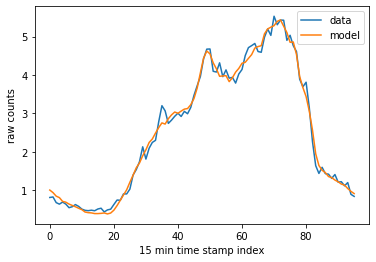

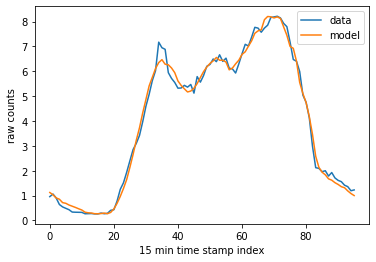

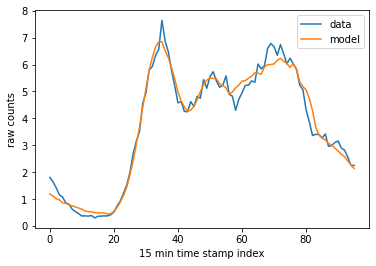

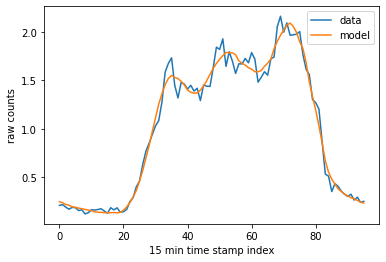

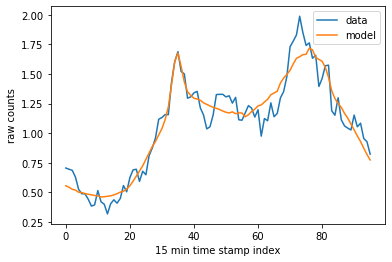

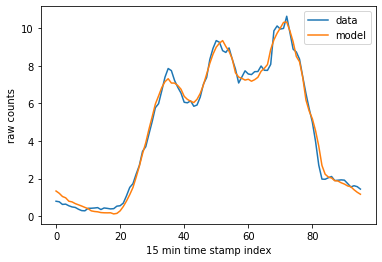

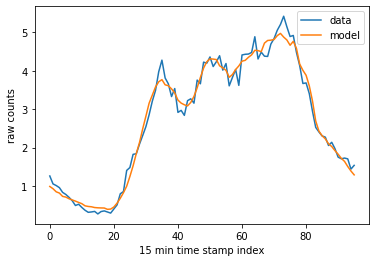

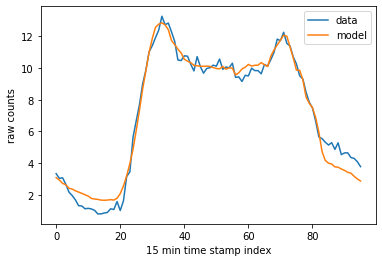

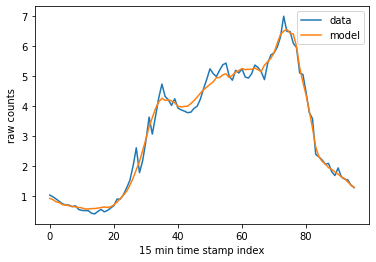

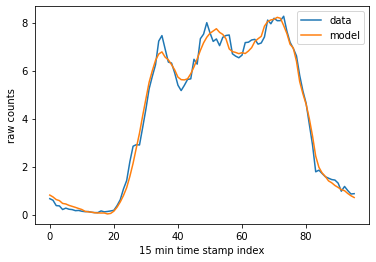

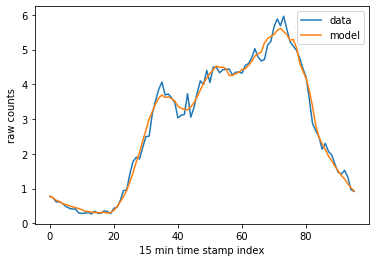

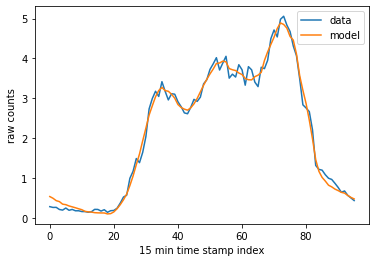

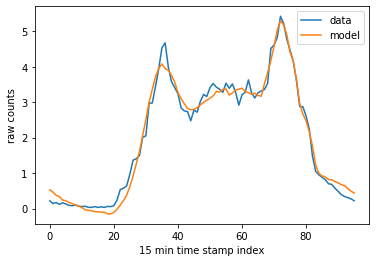

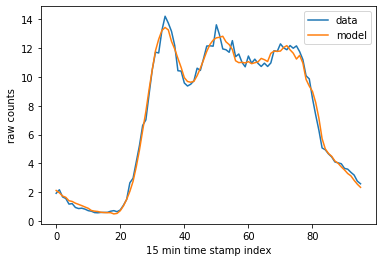

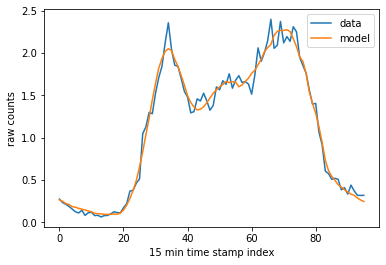

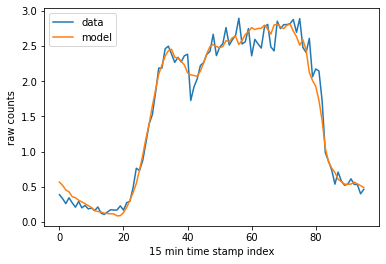

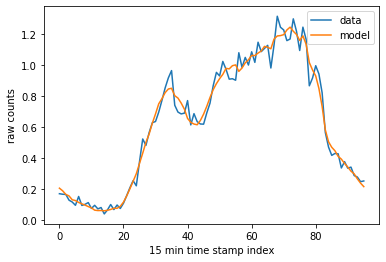

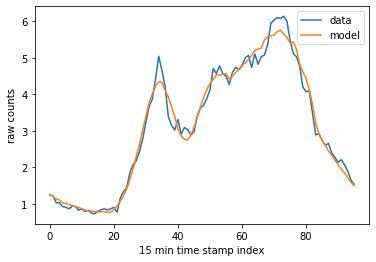

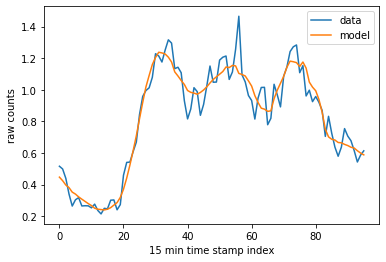

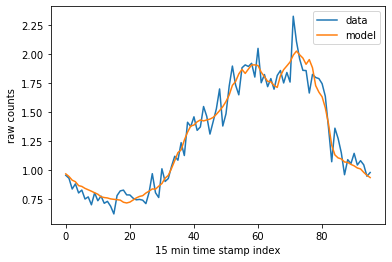

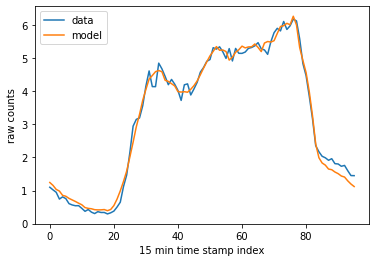

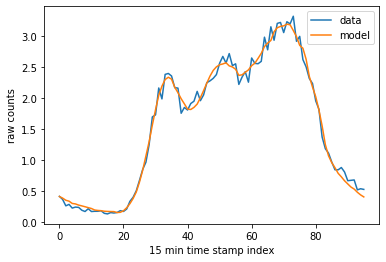

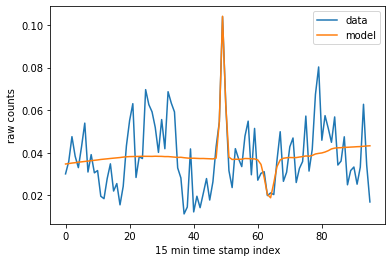

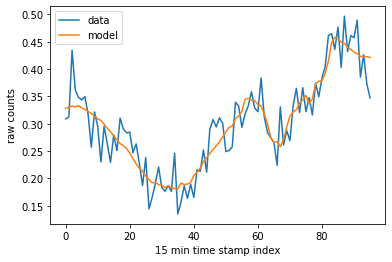

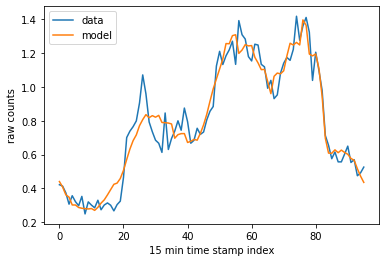

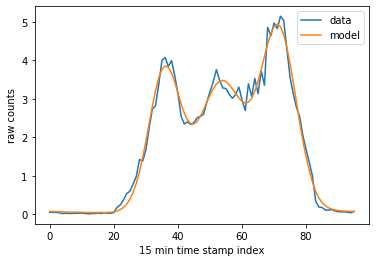

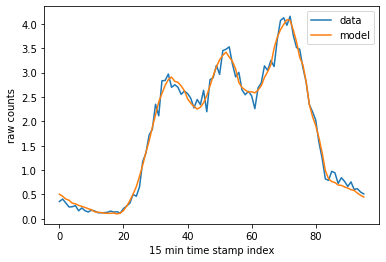

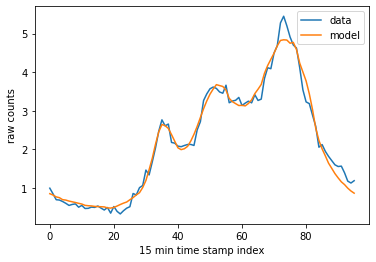

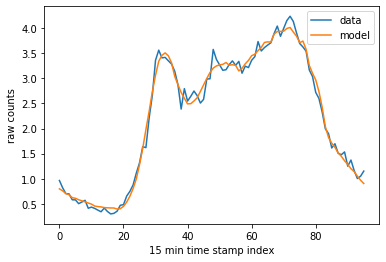

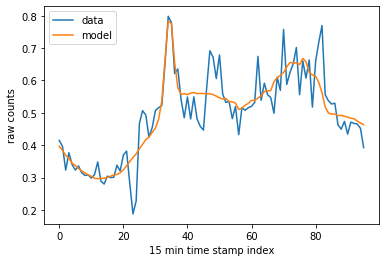

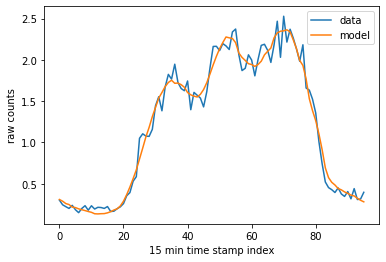

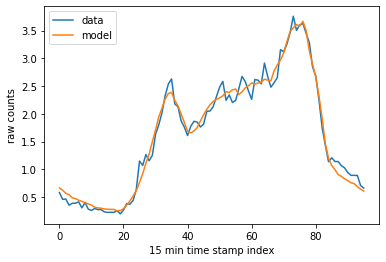

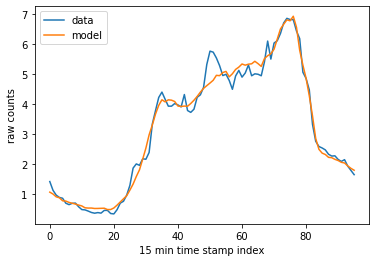

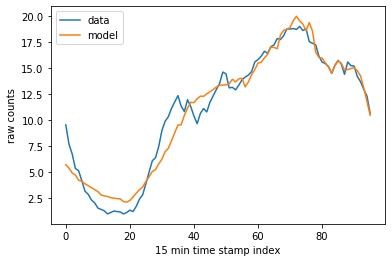

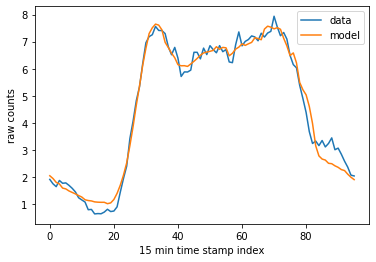

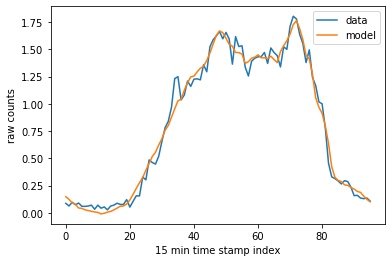

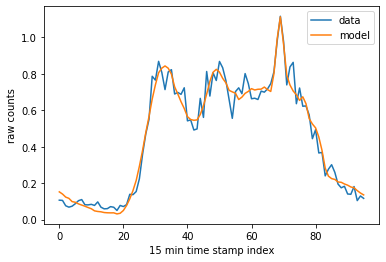

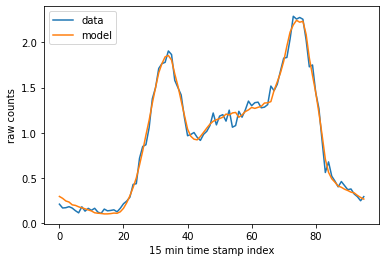

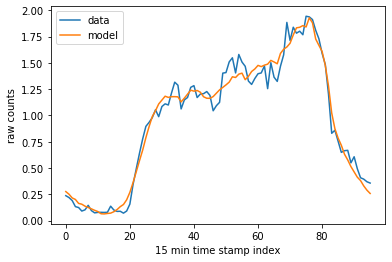

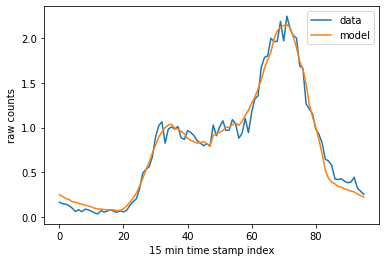

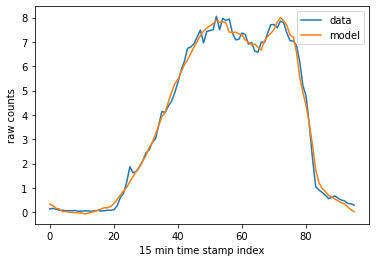

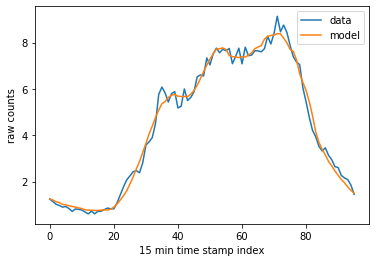

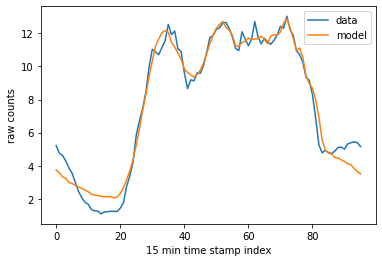

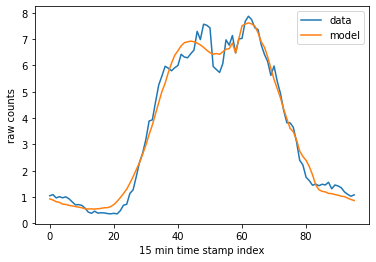

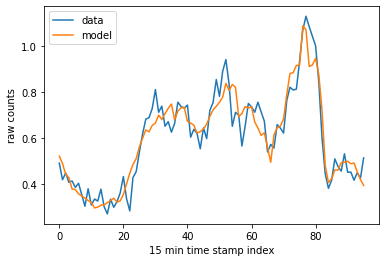

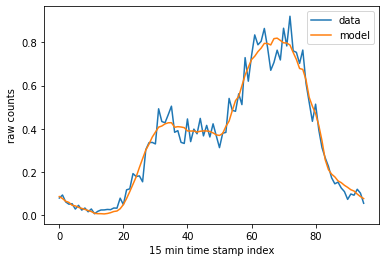

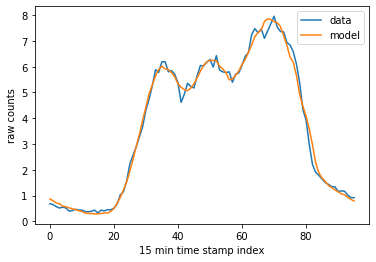

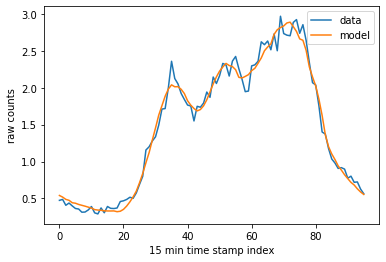

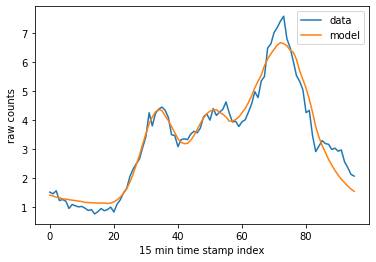

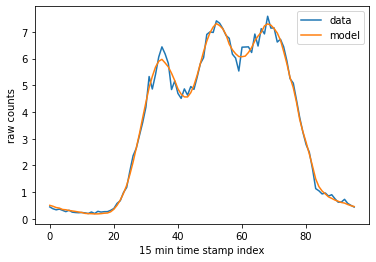

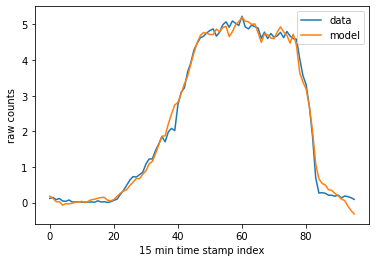

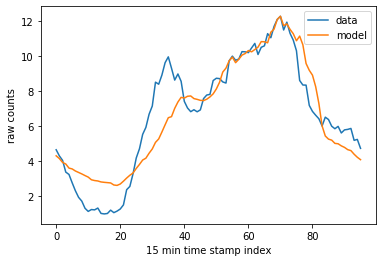

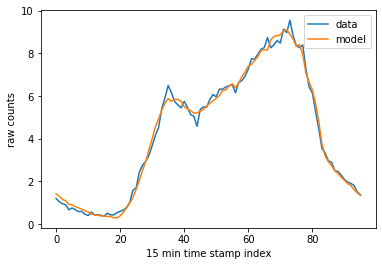

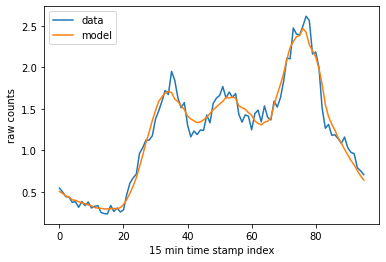

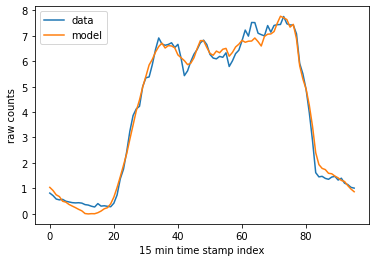

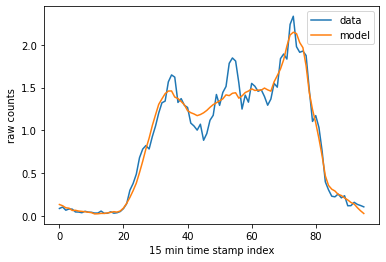

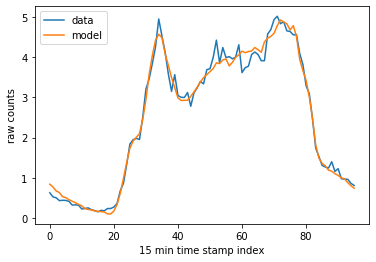

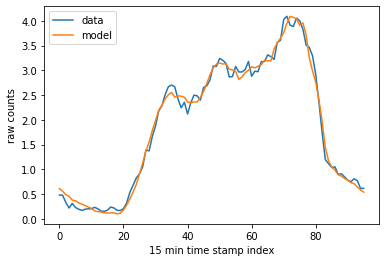

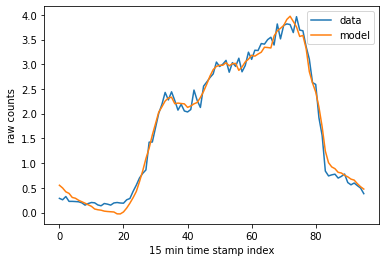

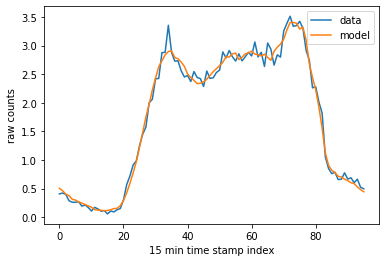

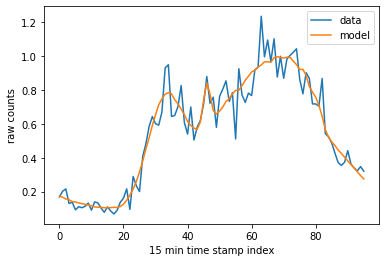

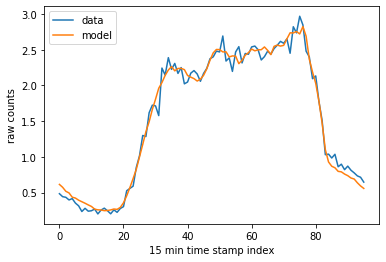

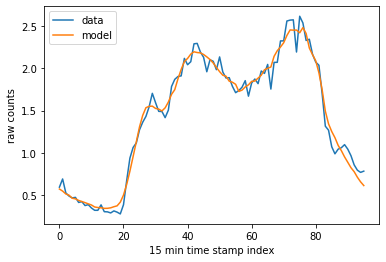

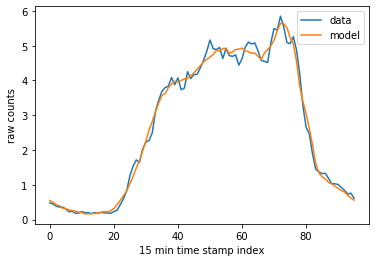

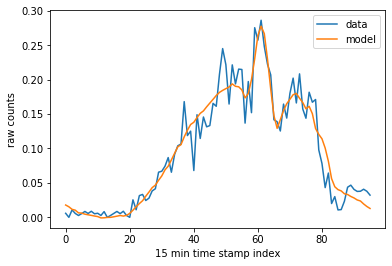

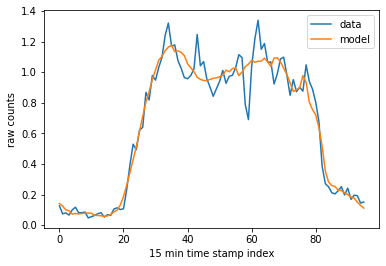

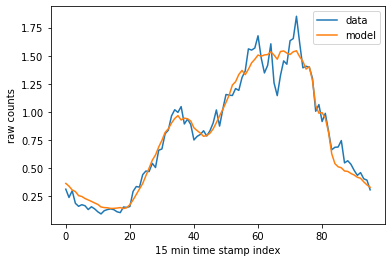

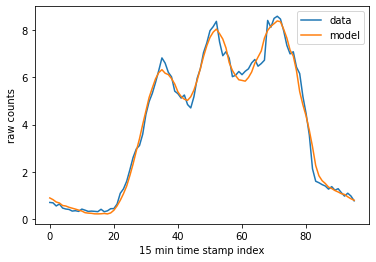

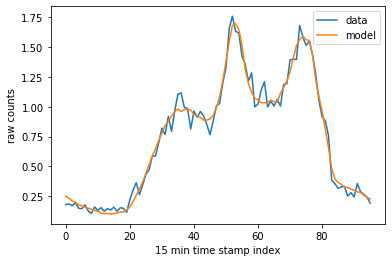

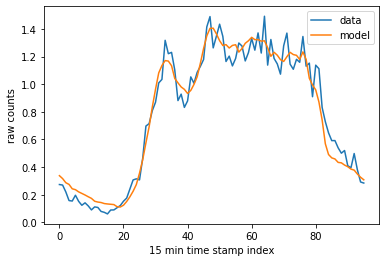

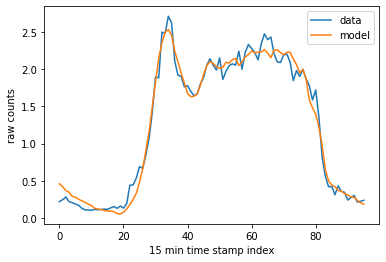

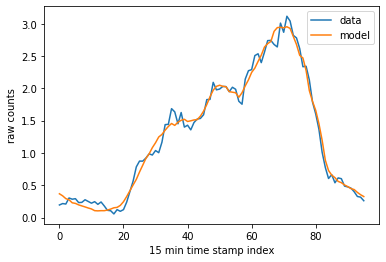

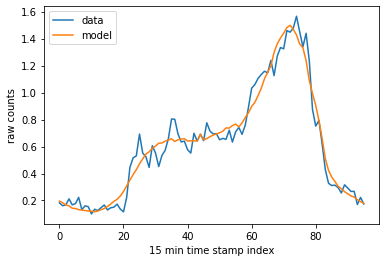

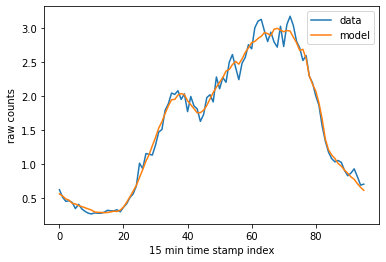

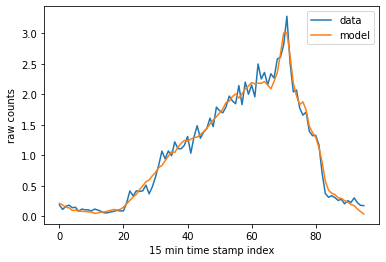

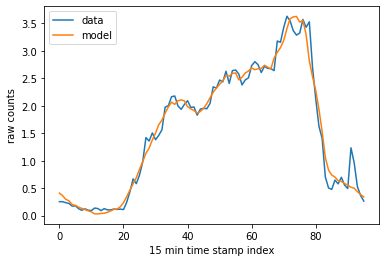

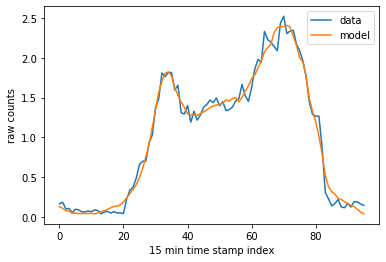

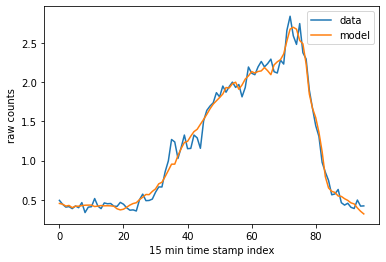

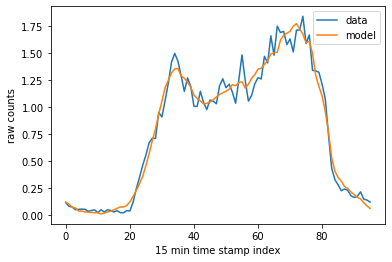

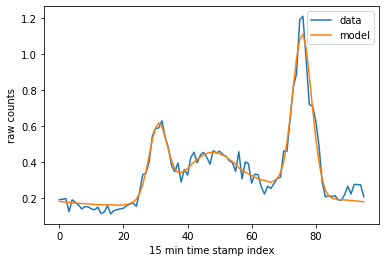

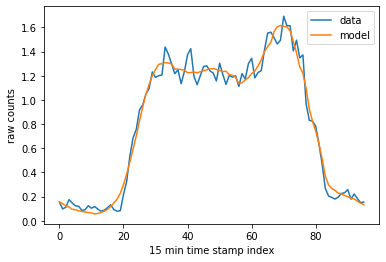

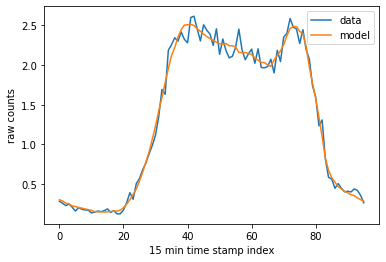

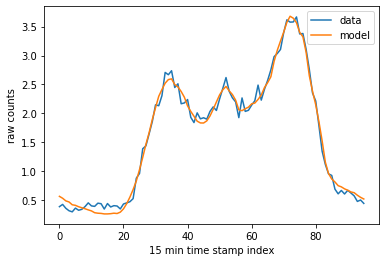

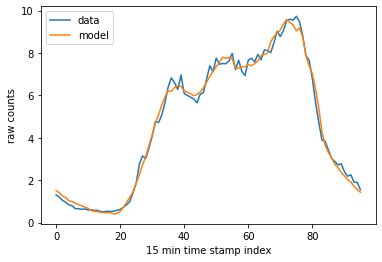

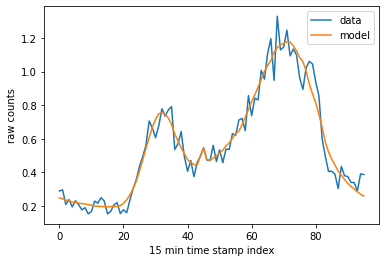

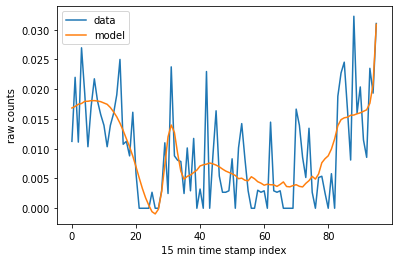

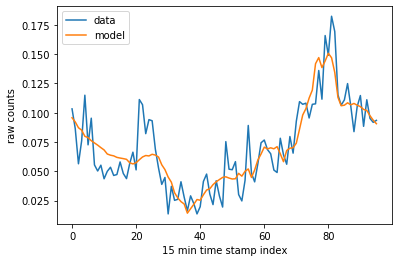

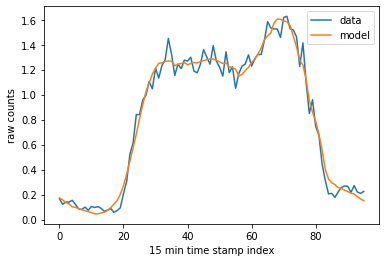

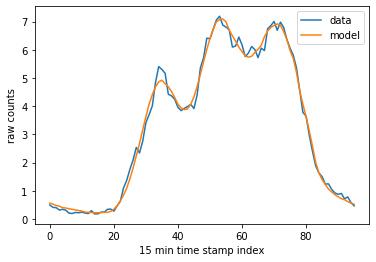

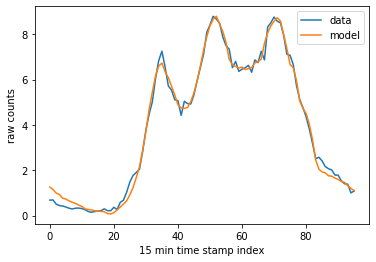

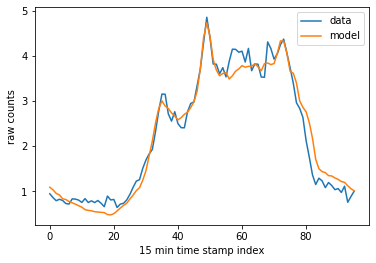

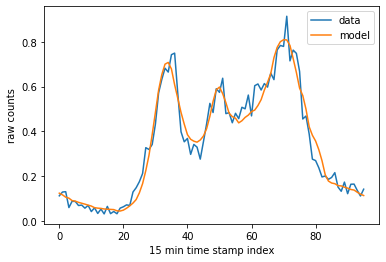

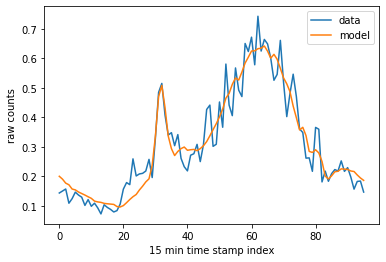

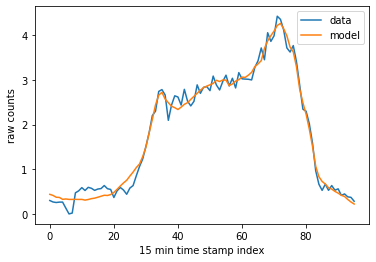

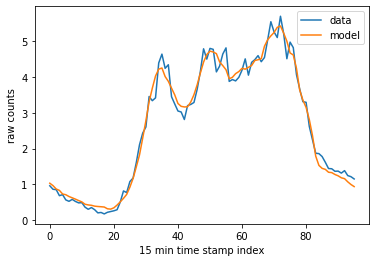

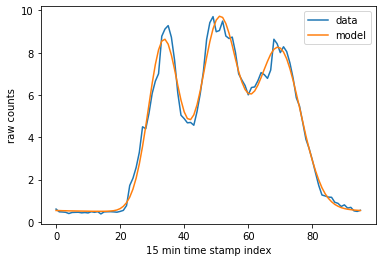

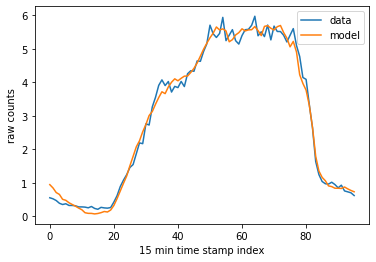

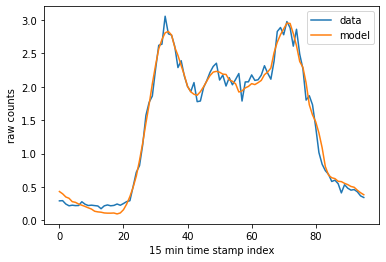

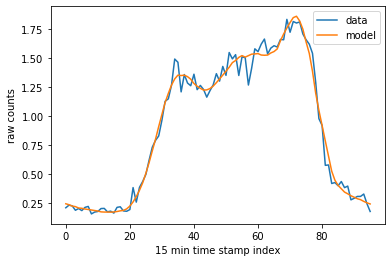

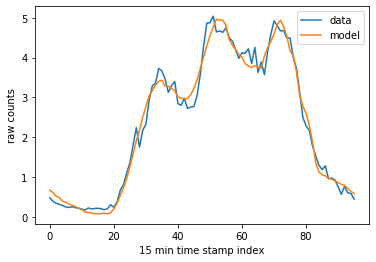

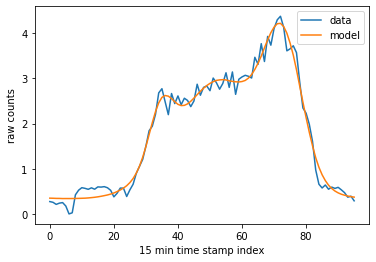

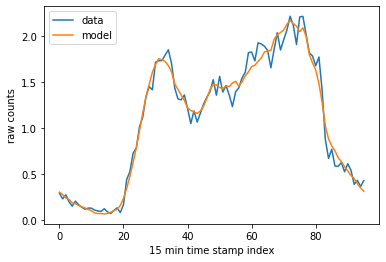

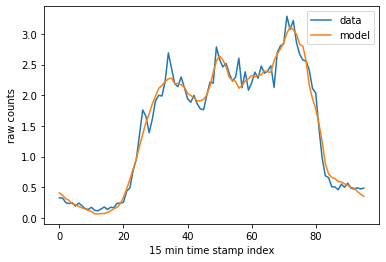

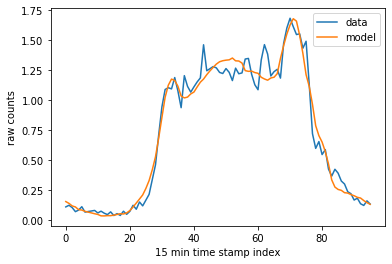

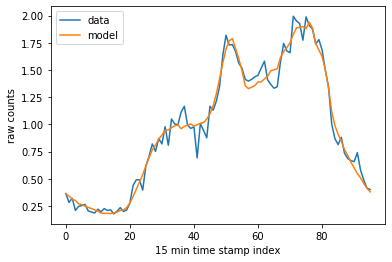

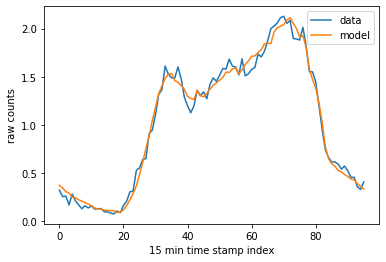

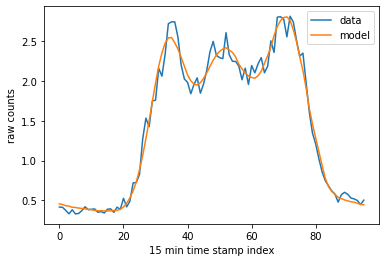

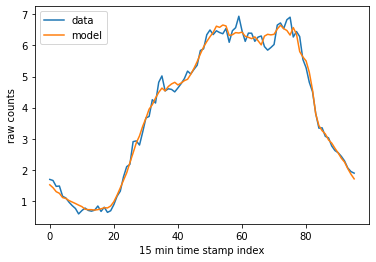

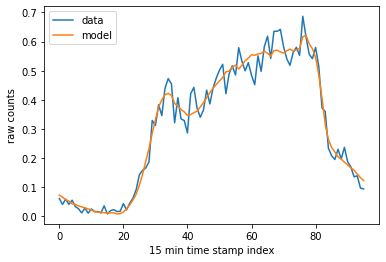

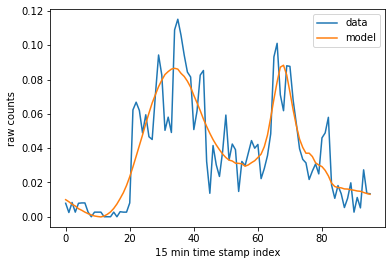

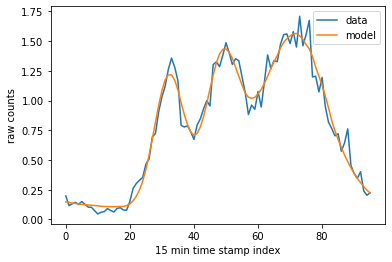

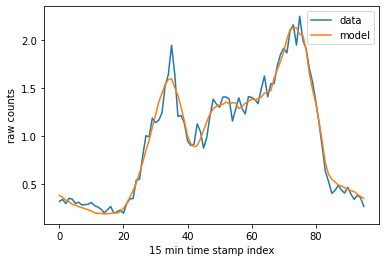

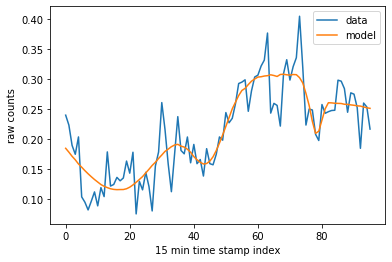

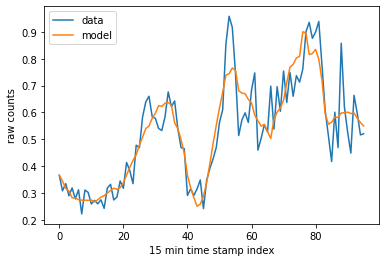

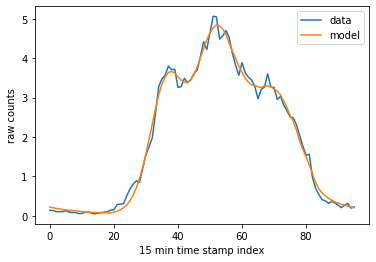

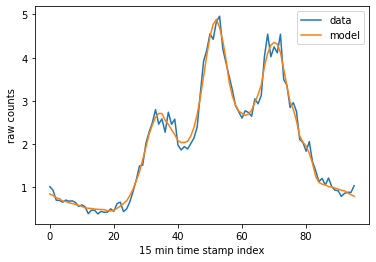

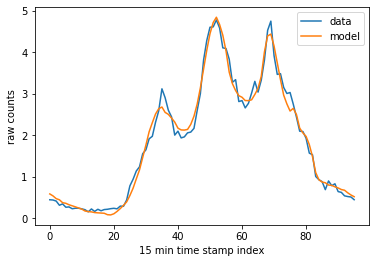

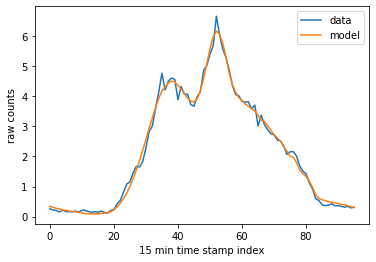

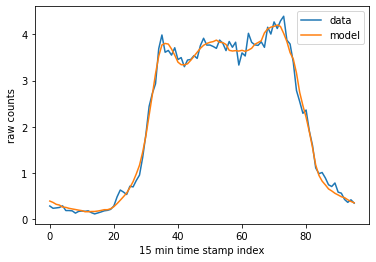

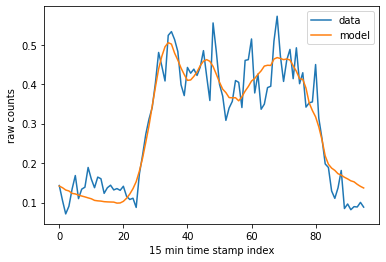

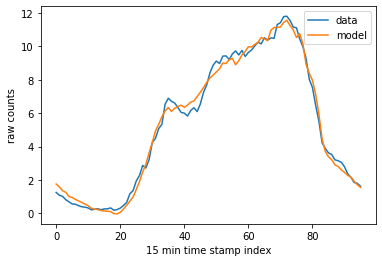

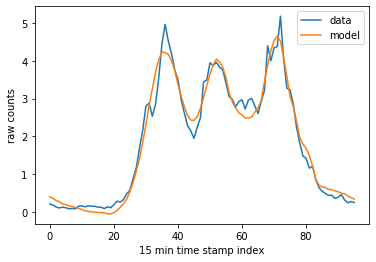

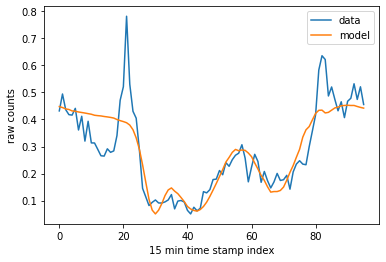

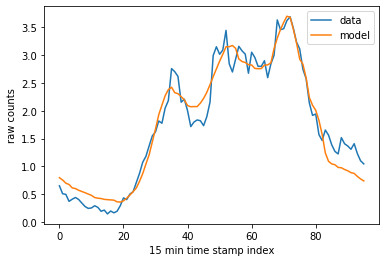

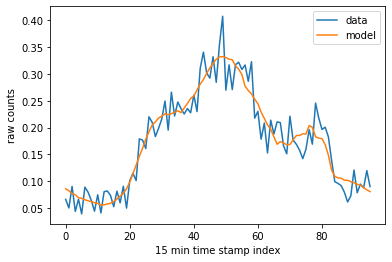

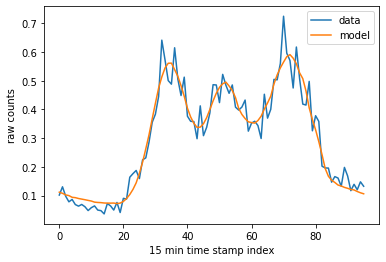

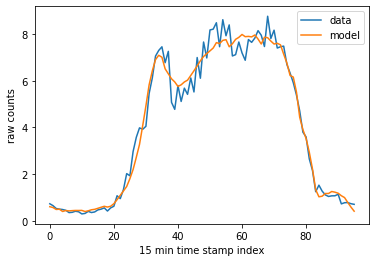

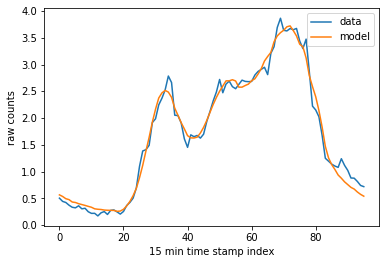

In [0]:
for i in range(len(plsq_final)):
  huatu(plsq_final[i][0], i, wendvals_t) #这里把前面转制的那个wendvals_t传进这个huatu函数


In [0]:
parr = np.vstack([i[0] for i in plsq_final])
parr
len(plsq_final)

157

In [0]:
print(parr[:, 0] < parr[:, 1])
print(parr[:, 1] < parr[:, 2])

[ True  True  True False  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True False False False
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True  True  True  True  True  True  True 

In [0]:
for i in range(157):
  if parr[i, 0] > parr[i, 1]:
    temp       = parr[i, 0]
    parr[i, 0] = parr[i, 1]
    parr[i, 1] = temp
    temp_sd    = parr[i, 3]
    parr[i, 3] = parr[i, 4]
    parr[i, 4] = temp_sd
    temp_scl   = parr[i, 6]
    parr[i, 6] = parr[i, 7]
    parr[i, 7] = temp_scl
#print(parr)

for i in range(157):
  if parr[i, 1] > parr[i, 2]:
    temp       = parr[i, 1]
    parr[i, 1] = parr[i, 2]
    parr[i, 2] = temp
    temp_sd    = parr[i, 4]
    parr[i, 4] = parr[i, 5]
    parr[i, 5] = temp_sd
    temp_scl   = parr[i, 7]
    parr[i, 7] = parr[i, 8]
    parr[i, 8] = temp_scl
#print(parr)

In [0]:
bind   = [5, 18, 19, 48, 51, 52, 66, 69, 72, 74, 79, 80, 81, 94, 95, 101, 102,
          103, 105, 113, 114, 115, 151, 121, 62, 141]
parr_final = parr[~parr.index.isin(bind)].reset_index(drop=True)

weekday_final = weekday[~weekday.index.isin(bind)].reset_index(drop=True)
lon_final = weekday_final["lon"]
lat_final = weekday_final["lat"]

parr_final.head()

NameError: ignored

In [0]:
parr_final = np.array(parr_final)

# -- convert means and widths to hours  
parr_final = pd.DataFrame(parr_final)

parr_final.columns = ["m1", "m2", "m3", "sig1", "sig2", "sig3", "scl1", "scl2", "scl3", "off"]   
parr_final = parr_final*0.25
parr_final

0         1          2         3   ...           12        13   14     15
0    2.242111  2.941546   8.875460  0.139692  ...   994.526079  0.059584  0.0  253.0
1    2.139745  3.508926   8.575297  0.247648  ...   686.304484  0.831737  0.0  180.0
2    1.966121  3.785970   9.984776  0.395120  ...  1712.178475  0.327725  0.0    8.0
3    2.242125  3.459012   9.419284  0.341418  ...  1024.628692  0.344312  1.0  201.0
4    2.093342  3.078232  10.073832  0.304335  ...  2083.623661  1.305032  1.0   36.0
..        ...       ...        ...       ...  ...          ...       ...  ...    ...
126  2.164942  3.343226  10.070465  0.334420  ...   619.321150  0.537304  2.0   75.0
127  1.815166  2.974944   9.169906  0.346335  ...    33.049028  0.342058  0.0    0.0
128  2.149759  3.221268   9.504733  0.323427  ...  1805.795521  1.086503  0.0    5.0
129  2.131451  3.179045   9.018249  0.336939  ...   426.143155  0.748897  1.0   88.0
130  2.039298  3.323033  10.190749  0.298031  ...  2195.678546  0.508225  0.0   66.0

[131 rows x 16 columns]

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

# plot

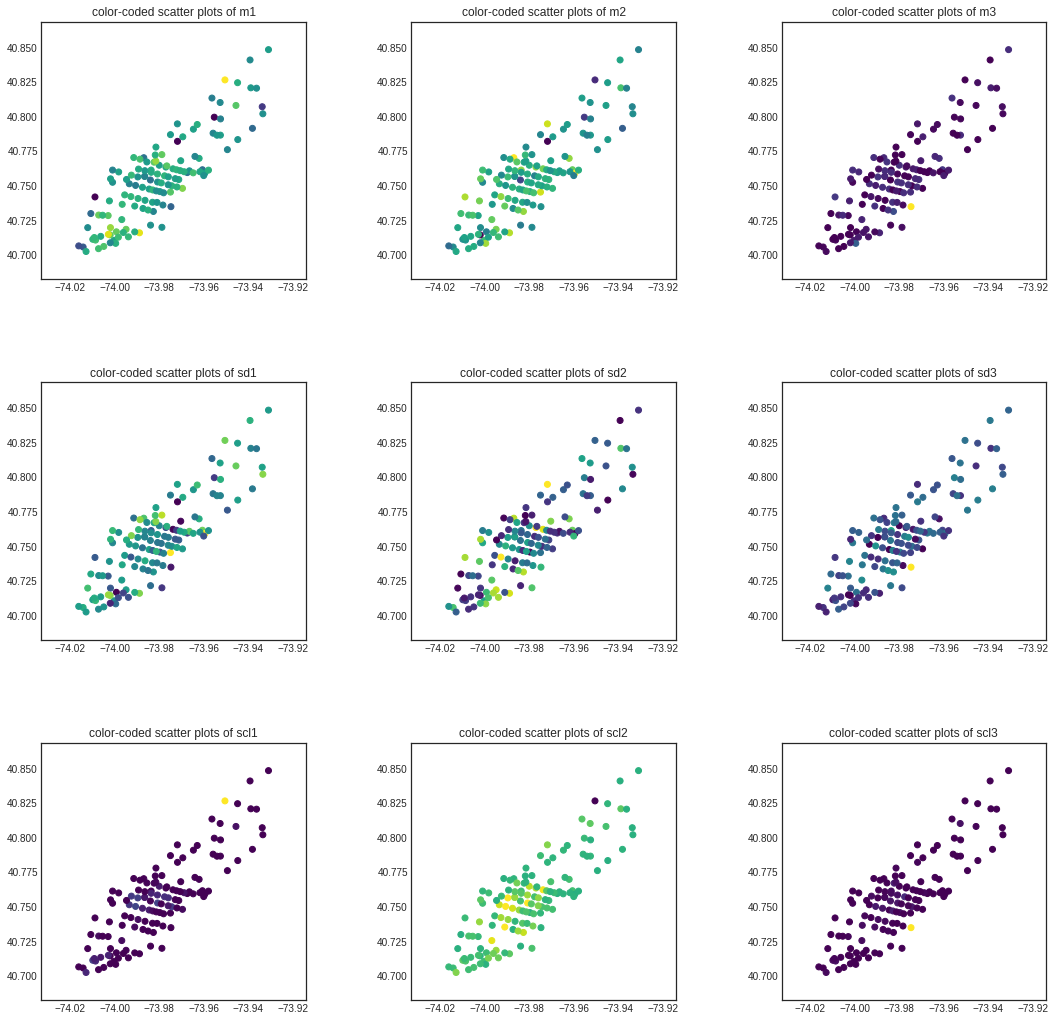

In [0]:
fig = plt.figure(figsize=(18, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    cscl = 0.1
    norm = (parr_final[i-1] - parr_final[i-1].min())
    norm /= norm.max()
    norm = ((1 + 2 * cscl) * norm - cscl).clip(0, 1)
    plt.scatter(lon_final, lat_final, c=plt.cm.viridis(norm))
    if i==1:
      plt.title("color-coded scatter plots of m1")
    else:
      if i==2:
        plt.title("color-coded scatter plots of m2")
      else:
        if i==3:
          plt.title("color-coded scatter plots of m3")
        else:
          if i==4:
            plt.title("color-coded scatter plots of sd1")
          else:
            if i==5:
              plt.title("color-coded scatter plots of sd2")
            else:
              if i==6:
                plt.title("color-coded scatter plots of sd3")
              else:
                if i==7:
                  plt.title("color-coded scatter plots of scl1")
                else:
                  if i==8:
                    plt.title("color-coded scatter plots of scl2")
                  else:
                    if i==9:
                      plt.title("color-coded scatter plots of scl3")

Text(0.5, 1.0, 'a color-coded plot of the ratio of the area under morning/afternoon')

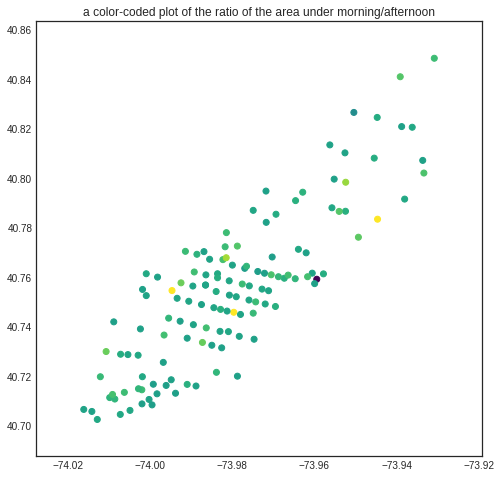

In [0]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cscl = 0.1
parr_ratio = parr_final[6]/parr_final[7]
norm_ratio = (parr_ratio - parr_ratio.min())
norm_ratio /= norm_ratio.max()
norm_ratio = ((1 + 2 * cscl) * norm_ratio - cscl).clip(0, 1)
plt.scatter(lon_final, lat_final, c=plt.cm.viridis(norm_ratio))
plt.title("a color-coded plot of the ratio of the area under morning/afternoon")


# multi regression

In [0]:
import os
# -- read the data
food_name = os.path.join("drive", "My Drive", "lwir", "data", "food_truck", "DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
restaurant = pd.read_csv(food_name, parse_dates=["INSPECTION DATE"])
#restaurant.head()


In [0]:
ind = (restaurant["INSPECTION DATE"] >= "2017-01-01") & \
  (restaurant["INSPECTION DATE"] < "2018-01-01") & \
  (restaurant["Latitude"] > 0.0) & \
  (restaurant["Longitude"] < 0.0) & \
  (restaurant["BORO"] == "Manhattan")
restaurant_sub = restaurant[ind]

In [0]:
# -- read in the counts    
# -- set the root directory for the project                                     
rpath = os.path.join("drive", "My Drive", "lwir")                                                     
cpath  = os.path.join(rpath, "data", "nycdot")
cname  = "cams_ft_wd.feather"
camdat = pd.read_feather(os.path.join(cpath, cname))
bind   = [5, 18, 19, 48, 51, 52, 66, 69, 72, 74, 79, 80, 81, 94, 95, 101, 102,
          103, 105, 113, 114, 115, 151, 121, 62, 141]
          # 0, 5, 7, 13, 18, 19, 48, 51, 52, 62, 69, 72, 79, 98, 99, 101, 102,
          # 104, 105, 109, 113, 114, 115, 151, 121, 125, 137, 141, 146, 151]
camdat = camdat[~camdat.index.isin(bind)].reset_index(drop=True)
camdat_lat = camdat["lat"].to_list()
camdat_lon = camdat["lon"].to_list()

# -- read in the parks data                                                     
ppath = os.path.join(rpath, "data", "parks", "properties")
pname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"
parks = gp.read_file(os.path.join(ppath, pname))
parks = parks[parks["borough"] == "M"]



In [0]:
# camera lat/lon transfer to NYS
import pyproj

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj("epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result

lon_mn, lat_mn = latlon_to_ny(camdat_lat, camdat_lon)
camdat_latlon = np.vstack((lat_mn, lon_mn)).T

#print(camdat_latlon)

In [0]:
"""  define helper function """
def npoints(x0, y0, lat, lon):
  
  """ convert lat/lon to NY State Plane """
  ll_nyspd = pyproj.Proj("epsg:2263", preserve_units=True)(lon, lat)

  results = (((ll_nyspd[1] - x0)**2 + (ll_nyspd[0] - y0)**2) <= 250000).sum()

  return results

In [0]:
lat_restaurant = restaurant_sub["Latitude"].to_list()
lon_restaurant = restaurant_sub["Longitude"].to_list()

restaurant_number = []

for i in range(len(camdat_latlon)): 
  size_point = npoints(camdat_latlon[i, 0], camdat_latlon[i, 1], lat_restaurant, lon_restaurant)
  restaurant_number.append(size_point)

len(restaurant_number)

131

In [0]:
benchs = gp.read_file("drive/My Drive/lwir/data/nyc_citybench/NYC_CityBench.shp")
benchs["Installati"] = pd.to_datetime(benchs["Installati"])
ind_thi = benchs["Installati"] <= "2017-09-11"
benches_number = benchs[ind_thi]
def convert_to_nyc(data):
  if (data.geometry.crs["init"] != "epsg:2263"):
    data.geometry = data.geometry.to_crs(epsg=2263)
benches_number['lon'] = benches_number['geometry'].x
benches_number['lat'] = benches_number['geometry'].y
benches_number

OBJECTID_1  SiteID  ...           lon            lat
0              1  2105.0  ...  9.967180e+05  194270.353307
1              2  3045.0  ...  9.822243e+05  204076.705413
2              3  3062.0  ...  1.017257e+06  209504.927169
3              4  3091.0  ...  1.001603e+06  241406.682591
4              5  3150.0  ...  9.501067e+05  160915.660502
...          ...     ...  ...           ...            ...
1597        1598  3362.0  ...  1.022820e+06  214789.233529
1598        1599  3442.0  ...  9.998440e+05  229162.767446
1599        1600  3544.0  ...  1.009714e+06  209687.289993
1600        1601  3497.0  ...  9.885826e+05  207791.490307
1601        1602  2746.0  ...  1.019209e+06  214097.509191

[1602 rows x 15 columns]

In [0]:
"""  define helper function """
def npoints_bench(x0, y0, lat, lon):
  
  results = (((lat - x0)**2 + (lon - y0)**2) <= 250000).sum()

  return results

In [0]:
lat_bench = benches_number["lat"].to_list()
lon_bench = benches_number["lon"].to_list()

number_bench = []

for i in range(len(camdat_latlon)): 
  bench_point = npoints_bench(camdat_latlon[i, 0], camdat_latlon[i, 1], lat_bench, lon_bench)
  number_bench.append(bench_point)


len(number_bench)

131

In [0]:
# -- read in the data
dname  = os.path.join("drive", "My Drive", "lwir", "output", 
                        "camdat_features.csv")
camdat = pd.read_csv(dname)
ind    = (camdat["pa500"] > 0.0) & (camdat["wc500"] > 0.0) & (camdat["rc500"] > 0.0) & (camdat["number_bench"] > 0.0) & (camdat["restaurant_number"] > 0.0)
camsub = camdat[ind]
import statsmodels.formula.api as sm

In [0]:
# -- convert means and widths to hours  
parr_final = pd.DataFrame(parr_final)

parr_final.columns = ["m1", "m2", "m3", "sig1", "sig2", "sig3", "scl1", "scl2", "scl3", "off"]   
parr_final = parr_final*0.25
parr_final

m1        m2         m3  ...      scl2       scl3       off
0    2.242111  2.941546   8.875460  ...  2.197932   5.846733  0.012543
1    2.139745  3.508926   8.575297  ...  2.112759  10.085081  0.061419
2    1.966121  3.785970   9.984776  ...  0.840823   0.115830  0.001564
3    2.242125  3.459012   9.419284  ...  7.968841   2.753906  0.020556
4    2.093342  3.078232  10.073832  ...  1.056447   2.430309  0.010597
..        ...       ...        ...  ...       ...        ...       ...
126  2.164942  3.343226  10.070465  ...  3.120323   4.017439  0.020924
127  1.815166  2.974944   9.169906  ...  0.328346   0.166380  0.004017
128  2.149759  3.221268   9.504733  ...  0.352410   0.548164  0.005505
129  2.131451  3.179045   9.018249  ...  6.863875   8.674127  0.033940
130  2.039298  3.323033  10.190749  ...  3.096870   4.016383  0.018352

[131 rows x 10 columns]

In [0]:
parr_final["pa500"] = camdat["pa500"] 
parr_final["wc500"] = camdat["wc500"] 
parr_final["rc500"] = camdat["rc500"] 
parr_final["strat"] = parr_final["scl1"]/parr_final["scl2"]
parr_final["number_bench"] = number_bench
parr_final["restaurant_number"] = restaurant_number
ind    = (parr_final["pa500"] > 0.0) & (parr_final["wc500"] > 0.0) & (parr_final["rc500"] > 0.0) & (parr_final["number_bench"] > 0.0) & (parr_final["restaurant_number"] > 0.0)
camsub = camdat[ind]

In [0]:
form0 = "srat ~ wc500 + rc500 + pa500 + number_bench + restaurant_number"
model0 = sm.ols(formula=form0, data=camsub).fit()

In [0]:
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   srat   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.459
Date:                Tue, 11 Feb 2020   Prob (F-statistic):              0.240
Time:                        08:23:27   Log-Likelihood:                -50.878
No. Observations:                  30   AIC:                             113.8
Df Residuals:                      24   BIC:                             122.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.6275      1.128      1.442      0.162      -0.701       3.956
wc500                -0.0001   5.05e-05     -2.250      0.034      -0.000   -9.38e-06
rc500                -0.0003      0.001     -0.505      0.618      -0.002       0.001
pa500                 0.0790      0.177      0.446      0.660      -0.287       0.444
number_bench          0.1204      0.273      0.441      0.663      -0.443       0.684
restaurant_number     0.0116      0.007      1.760      0.091      -0.002       0.025
==============================================================================
Omnibus:                        6.718   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                5.440
Skew:                           1.027   Prob(JB):                       0.0659
Kurtosis:                       3.361   Cond. No.                     3.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""